<a href="https://colab.research.google.com/github/wantor-stack/Demand-Forecasting/blob/main/ensemble_models_1359_Y1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Forecast for Product 1359 Demand 




# Preprocessing

In [ ]:
! pip install pycaret

In [ ]:
!pip install fastparquet

In [ ]:
import matplotlib.pyplot as plt

plt.style.use('seaborn')

In [ ]:
# read the parquet file
import pandas as pd
data = pd.read_parquet("stacked_df.parquet").sort_values("Date")

In [ ]:
data.head()

,Warehouse,Product_Category,Product_Code,Date,Order_Demand
12782,Whse_A,Category_005,Product_0001,2012-01-01,0.0
825352,Whse_C,Category_005,Product_0469,2012-01-01,0.0
4806032,Whse_S,Category_021,Product_0337,2012-01-01,0.0
942216,Whse_C,Category_015,Product_0463,2012-01-01,0.0
4807858,Whse_S,Category_021,Product_0342,2012-01-01,0.0


In [ ]:
# combine store and item column as time_series

data['Warehouse'] = ['warehouse_' + str(i) for i in data['Warehouse']]
data['Product_Code'] = ['Product_Code' + str(i) for i in data['Product_Code']]
data['time_series'] = data[['Warehouse', 'Product_Code']].apply(lambda x: '_'.join(x), axis=1)
data.drop(['Warehouse', 'Product_Category','Product_Code'], axis=1, inplace=True)

In [ ]:
# extract features from date
data['day'] = [i.day for i in data['Date']]
data['month'] = [i.month for i in data['Date']]
data['year'] = [i.year for i in data['Date']]
data['day_of_week'] = [i.dayofweek for i in data['Date']]
data['day_of_year'] = [i.dayofyear for i in data['Date']]
data['week'] = [i.week for i in data['Date']]


In [ ]:
data = data.sort_values(by=['time_series','Date'])

In [ ]:
# Target

data['Y1'] = data['Order_Demand'].shift(-1)

In [ ]:
data_1359 = data[data['time_series'] == 'warehouse_Whse_J_Product_CodeProduct_1359']

In [ ]:
data_1359.head(10)

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1
3204630,2012-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2012,6,1,52,0.0
3204631,2012-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2012,0,2,1,0.0
3204632,2012-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2012,1,3,1,0.0
3204633,2012-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2012,2,4,1,702000.0
3204634,2012-01-05,702000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2012,3,5,1,676000.0
3204635,2012-01-06,676000.0,warehouse_Whse_J_Product_CodeProduct_1359,6,1,2012,4,6,1,0.0
3204636,2012-01-07,0.0,warehouse_Whse_J_Product_CodeProduct_1359,7,1,2012,5,7,1,0.0
3204637,2012-01-08,0.0,warehouse_Whse_J_Product_CodeProduct_1359,8,1,2012,6,8,1,0.0
3204638,2012-01-09,0.0,warehouse_Whse_J_Product_CodeProduct_1359,9,1,2012,0,9,2,783000.0
3204639,2012-01-10,783000.0,warehouse_Whse_J_Product_CodeProduct_1359,10,1,2012,1,10,2,200000.0


In [ ]:
# Split

split_year = 2015

data_train_1359 = data_1359[data_1359['year'] <= split_year]
data_val_1359 = data_1359[(data_1359['year'] > split_year) & (data_1359['month'] <= 6)]
data_test_1359 = data_1359[(data_1359['year'] > split_year) & (data_1359['month'] > 6)]

data_train_1359.shape, data_val_1359.shape, data_test_1359.shape


((1461, 10), (182, 10), (183, 10))

In [ ]:
data_train_1359.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1
3204630,2012-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2012,6,1,52,0.0
3204631,2012-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2012,0,2,1,0.0
3204632,2012-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2012,1,3,1,0.0
3204633,2012-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2012,2,4,1,702000.0
3204634,2012-01-05,702000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2012,3,5,1,676000.0


# 3. Feature Engineering + Random Forest Regressor

In [ ]:
lags = [2,4,7,15,30,60]
train2 = data_train_1359.copy()
new_features = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            train2['LAG{}_{}'.format(l, f)] = train2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            train2['DIFF{}_{}'.format(l, f)] = train2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            train2['ROLL_MEAN{}_{}'.format(l, f)] = train2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            train2['ROLL_MAX{}_{}'.format(l, f)] = train2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train2['ROLL_MIN{}_{}'.format(l, f)] = train2[f].rolling(l).min()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            train2['ROLL_MIN{}_{}'.format(l, f)] = train2[f].rolling(l).std()

            #new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            #train2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = train2[f] - train2[f].rolling(l).mean()

In [ ]:
train2 = train2.dropna()

In [ ]:
train2

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1,LAG2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,LAG4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,LAG7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,LAG15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,LAG30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,LAG60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand
3204690,2012-03-01,720000.0,warehouse_Whse_J_Product_CodeProduct_1359,1,3,2012,3,61,9,465000.0,163000.0,584500.0,720000.0,449000.0,0.0,438000.0,720000.0,163000.0,329000.0,265714.285714,720000.0,0.0,229000.0,269266.666667,720000.0,0.0,1399000.0,295033.333333,1073000.0,0.0,0.0,296033.333333,1399000.0,0.0
3204691,2012-03-02,465000.0,warehouse_Whse_J_Product_CodeProduct_1359,2,3,2012,4,62,9,0.0,449000.0,592500.0,720000.0,465000.0,420000.0,449250.0,720000.0,163000.0,108000.0,316714.285714,720000.0,0.0,401000.0,273533.333333,720000.0,0.0,450000.0,295533.333333,1073000.0,0.0,0.0,303783.333333,1399000.0,0.0
3204692,2012-03-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,3,2012,5,63,9,0.0,720000.0,232500.0,465000.0,0.0,163000.0,408500.0,720000.0,0.0,0.0,316714.285714,720000.0,0.0,298000.0,253666.666667,720000.0,0.0,445000.0,280700.000000,1073000.0,0.0,0.0,303783.333333,1399000.0,0.0
3204693,2012-03-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,3,2012,6,64,9,761000.0,465000.0,0.0,0.0,0.0,449000.0,296250.0,720000.0,0.0,0.0,316714.285714,720000.0,0.0,0.0,253666.666667,720000.0,0.0,390000.0,267700.000000,1073000.0,0.0,0.0,303783.333333,1399000.0,0.0
3204694,2012-03-05,761000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,3,2012,0,65,10,487000.0,0.0,380500.0,761000.0,0.0,720000.0,306500.0,761000.0,0.0,420000.0,365428.571429,761000.0,0.0,0.0,304400.000000,761000.0,0.0,0.0,293066.666667,1073000.0,0.0,702000.0,304766.666667,1399000.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3206086,2015-12-27,0.0,warehouse_Whse_J_Product_CodeProduct_1359,27,12,2015,6,361,52,507000.0,98000.0,0.0,0.0,0.0,0.0,81750.0,229000.0,0.0,0.0,112000.000000,236000.0,0.0,0.0,218800.000000,1433000.0,0.0,272000.0,216300.000000,1433000.0,0.0,301000.0,234916.666667,1542000.0,0.0
3206087,2015-12-28,507000.0,warehouse_Whse_J_Product_CodeProduct_1359,28,12,2015,0,362,53,0.0,0.0,253500.0,507000.0,0.0,229000.0,151250.0,507000.0,0.0,221000.0,152857.142857,507000.0,0.0,0.0,252600.000000,1433000.0,0.0,0.0,233200.000000,1433000.0,0.0,132000.0,241166.666667,1542000.0,0.0
3206088,2015-12-29,0.0,warehouse_Whse_J_Product_CodeProduct_1359,29,12,2015,1,363,53,0.0,0.0,253500.0,507000.0,0.0,98000.0,126750.0,507000.0,0.0,236000.0,119142.857143,507000.0,0.0,166000.0,241533.333333,1433000.0,0.0,0.0,233200.000000,1433000.0,0.0,451000.0,233650.000000,1542000.0,0.0
3206089,2015-12-30,0.0,warehouse_Whse_J_Product_CodeProduct_1359,30,12,2015,2,364,53,0.0,507000.0,0.0,0.0,0.0,0.0,126750.0,507000.0,0.0,0.0,119142.857143,507000.0,0.0,1433000.0,146000.000000,507000.0,0.0,193000.0,226766.666667,1433000.0,0.0,0.0,233650.000000,1542000.0,0.0


In [ ]:
from pycaret.regression import *
exp_reg102 = setup(train2, target = 'Y1', train_size = 0.80,
              data_split_shuffle = False, 
              normalize = True, 
              transformation = True, 
              transform_target = True, #log
              combine_rare_levels = True, rare_level_threshold = 0.05,
              remove_multicollinearity = True, multicollinearity_threshold = 0.95,
              ignore_features = ['Date','time_series','Order_Demand'],
              numeric_features = ['month', 'day_of_week', 'day','week','day_of_year', 'year'] + list(new_features),
              #categorical_features = ['month', 'day_of_week', 'day','week'],
              silent = True, verbose = False, session_id = 123)

In [ ]:
top3 = compare_models(exclude = ['ransac'], n_select = 3)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,159109.0804,6.014351e+10,243764.1969,0.2865,4.9125,1.4486,0.334
gbr,Gradient Boosting Regressor,167730.0672,6.306825e+10,249242.7875,0.2563,6.0349,1.2848,0.180
rf,Random Forest Regressor,159283.3393,6.194454e+10,247032.7744,0.2543,4.0060,1.3661,0.567
ridge,Ridge Regression,185633.3891,6.771440e+10,258321.2938,0.2123,6.5363,1.8383,0.010
llar,Lasso Least Angle Regression,185638.0840,6.771625e+10,258328.1079,0.2122,6.5307,1.8379,0.012
lr,Linear Regression,185654.7438,6.772539e+10,258346.1750,0.2121,6.5282,1.8380,0.229
lasso,Lasso Regression,185654.1906,6.772509e+10,258345.5938,0.2121,6.5277,1.8380,0.012
br,Bayesian Ridge,186950.2973,6.830759e+10,259409.2073,0.2065,6.5994,1.8490,0.011
lightgbm,Light Gradient Boosting Machine,174831.9722,6.679096e+10,257022.4991,0.1995,6.0443,1.4398,0.140
huber,Huber Regressor,175964.4679,6.972750e+10,262061.1186,0.1920,6.3173,1.5338,0.017


In [ ]:
# train individual models to blend
boost = create_model('gbr', verbose = False)
knn = create_model('knn', verbose = False)
lr = create_model('lr', verbose = False)

In [ ]:
# blend individual models
blender = blend_models(estimator_list = [boost, knn, lr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,131079.6474,3.145389e+10,177352.4334,0.4087,5.4201,0.6589
1,166582.8502,4.958855e+10,222684.8631,0.1392,6.1712,4.9314
2,173876.1352,5.946763e+10,243859.8633,0.3998,6.7571,0.7139
3,172426.3793,6.527666e+10,255492.9695,0.2897,6.3467,0.7300
4,165326.8133,5.392387e+10,232215.1469,0.3589,5.9420,2.2759
5,187901.1912,9.257790e+10,304266.1704,0.2358,6.5921,0.8123
6,166450.8289,6.257521e+10,250150.3835,0.2749,6.2450,0.7306
7,163480.3425,5.234034e+10,228780.1140,0.3379,6.2042,4.5861
8,180371.7723,6.525482e+10,255450.2228,0.3085,6.5684,0.7164
9,196300.8078,7.752460e+10,278432.3932,0.1762,7.0047,1.2092


In [ ]:
tuned_top3 = tune_model(blender)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,127907.0156,3.087590e+10,175715.3999,0.4196,5.2100,0.6689
1,164368.4225,5.243305e+10,228982.6305,0.0898,5.9036,4.0765
2,169204.2663,5.882995e+10,242548.8578,0.4063,6.6368,0.7284
3,171429.0079,6.447530e+10,253919.8678,0.2984,6.1742,0.7362
4,160850.9973,5.226396e+10,228613.1307,0.3786,5.8070,2.3148
5,186093.3173,9.066880e+10,301112.6057,0.2516,6.4453,0.8339
6,161582.3169,6.074936e+10,246473.8570,0.2961,6.1306,0.7468
7,160661.1649,5.190968e+10,227836.9601,0.3434,6.0513,4.2489
8,177994.2278,6.567948e+10,256280.0821,0.3040,6.3956,0.7356
9,194058.4361,7.828620e+10,279796.7189,0.1681,6.9369,1.1934


In [ ]:
bagged_top = blend_models(estimator_list = top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,125804.5310,3.335304e+10,182628.1523,0.3730,4.8640,0.7508
1,187018.2129,7.136751e+10,267146.9744,-0.2388,5.6545,2.2465
2,162550.7593,5.938143e+10,243683.0518,0.4007,5.9673,0.7931
3,159551.7868,5.981685e+10,244574.8349,0.3491,5.5784,0.7409
4,145459.0609,4.687535e+10,216507.1573,0.4427,5.0450,1.9638
5,174364.1155,8.544213e+10,292304.8497,0.2947,6.0182,0.8623
6,145250.8144,5.380977e+10,231969.3327,0.3765,5.4820,0.7117
7,147111.5922,4.747783e+10,217894.0822,0.3994,5.3533,3.9159
8,167604.8363,6.393058e+10,252844.9795,0.3225,5.6313,0.7770
9,176012.9226,7.168628e+10,267742.9366,0.2383,6.2575,1.3518


In [ ]:
#lightgbm = create_model('lightgbm')
stacker2 = stack_models(top3)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,130830.0694,3.391313e+10,184155.1915,0.3625,5.1839,0.8456
1,183070.6906,6.322611e+10,251448.0198,-0.0975,5.8817,2.7748
2,167391.9946,6.332562e+10,251645.8211,0.3609,6.5374,0.7484
3,165544.7919,6.066481e+10,246302.2801,0.3399,6.1010,0.7370
4,160590.8831,5.239753e+10,228905.0658,0.3770,5.9222,1.7946
5,185341.9756,9.054684e+10,300910.0136,0.2526,6.6546,0.8137
6,153017.5454,5.723790e+10,239244.4264,0.3368,6.1278,0.6343
7,155571.9749,4.925405e+10,221932.5341,0.3770,5.9335,3.8498
8,173347.0273,6.386439e+10,252714.0415,0.3232,6.2698,0.7252
9,180687.1908,7.393926e+10,271917.7371,0.2143,6.6299,1.2476


In [ ]:
!pip install shap

     |████████████████████████████████| 358kB 15.6MB/s 
  Created wheel for shap: filename=shap-0.39.0-cp37-cp37m-linux_x86_64.whl size=491632 sha256=a630994522294460fb1c22bdd63cdba5ff54566b5d8cef3ce335190a895d295e
  Stored in directory: /root/.cache/pip/wheels/15/27/f5/a8ab9da52fd159aae6477b5ede6eaaec69fd130fa0fa59f283
Successfully built shap


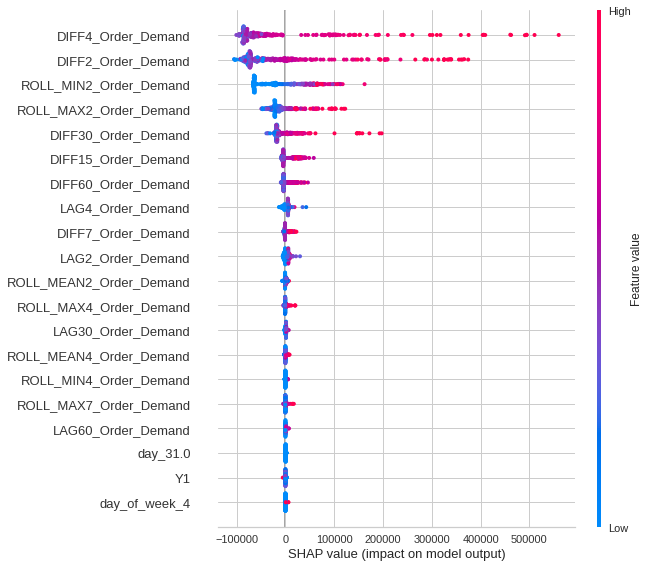

In [ ]:
interpret_model(rf)

## 3.1 Predict on Test / Hold-out Sample

Before finalizing the model, it is advisable to perform one final check by predicting the test/hold-out set and reviewing the evaluation metrics. If you look at the information grid in Section 6 above, you will see that 30% (1621 samples) of the data has been separated out as a test/hold-out sample. All of the evaluation metrics we have seen above are cross-validated results based on training set (70%) only. Now, using our final trained model stored in the tuned_rf variable we will predict the hold-out sample and evaluate the metrics to see if they are materially different than the CV results.

In [ ]:
predict_model(tuned_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,15527.1266,1.044605e+09,32320.3505,0.9901,2.2095,0.1271


## 3.2 Finalize Model for Deployment

In [ ]:
final_rf = finalize_model(tuned_rf)

In [ ]:
print(final_rf)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=9, max_features=1.0, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.1,
                      min_impurity_split=None, min_samples_leaf=4,
                      min_samples_split=7, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=-1, oob_score=False,
                      random_state=123, verbose=0, warm_start=False)


In [ ]:
predict_model(final_rf);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Random Forest Regressor,8403.646,3.450270e+08,18574.9026,0.9967,2.816,0.0687


## 3.3 Predict on Unseen Data

In [ ]:
lags = [2,4,7,15,30,60]
val2 = data_val_1359.copy()
new_features2 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            val2['LAG{}_{}'.format(l, f)] = val2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            val2['DIFF{}_{}'.format(l, f)] = val2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            val2['ROLL_MEAN{}_{}'.format(l, f)] = val2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            val2['ROLL_MAX{}_{}'.format(l, f)] = val2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            val2['ROLL_MIN{}_{}'.format(l, f)] = val2[f].rolling(l).min()

            #new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            #val2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = val2[f] - val2[f].rolling(l).mean()

In [ ]:
val2 = val2.fillna(-1)

In [ ]:
unseen_predictions = predict_model(final_rf, data=val2)
unseen_predictions.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,Label
3206091,2016-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2016,4,1,53,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,122.963064
3206092,2016-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2016,5,2,53,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,108.126345
3206093,2016-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2016,6,3,53,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,108.126345
3206094,2016-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2016,0,4,1,479000.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,128.091403
3206095,2016-01-05,479000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2016,1,5,1,605000.0,0.0,479000.0,239500.0,479000.0,0.0,0.0,479000.0,119750.0,479000.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,475333.231213


In [ ]:
from pycaret.utils import check_metric
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'R2'))
print(check_metric(unseen_predictions.Order_Demand, unseen_predictions.Label, 'MAE'))

0.9809
14810.0322


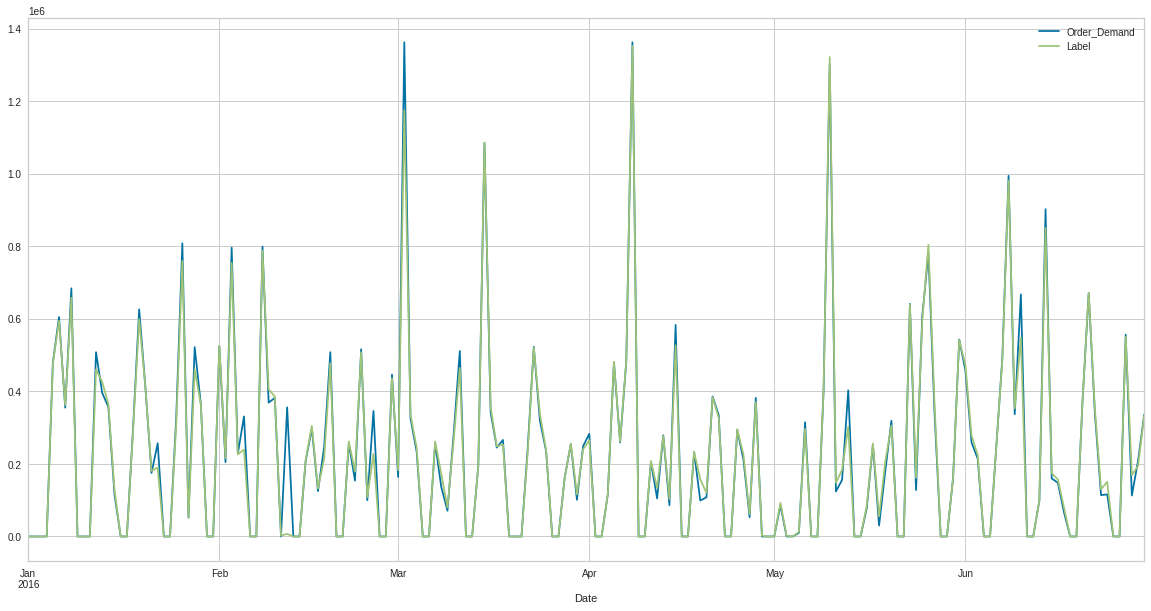

In [ ]:
unseen_predictions.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

## 3.4 Saving the Model

In [ ]:
save_model(final_rf,'Final Random Forest Model 1359 28 Jun 2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week',
                                                             'day', 'week'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year', 'year',
                                                           'Y1'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='...
                  RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                        criterion='mse', max_depth=9,
         

## 3.5 Loading the Saved Model

In [ ]:
lags = [2,4,7,15,30,60]
test2 = data_test_1359.copy()
new_features3 = set()
features=["Order_Demand"]

for f in features:
        for l in lags:
            new_features.add('LAG{}_{}'.format(l, f))
            test2['LAG{}_{}'.format(l, f)] = test2[f].shift(l)

            new_features.add('DIFF{}_{}'.format(l, f))
            test2['DIFF{}_{}'.format(l, f)] = test2[f].diff(l)

            new_features.add('ROLL_MEAN{}_{}'.format(l, f))
            test2['ROLL_MEAN{}_{}'.format(l, f)] = test2[f].rolling(l).mean()

            new_features.add('ROLL_MAX{}_{}'.format(l, f))
            test2['ROLL_MAX{}_{}'.format(l, f)] = test2[f].rolling(l).max()

            new_features.add('ROLL_MIN{}_{}'.format(l, f))
            test2['ROLL_MIN{}_{}'.format(l, f)] = test2[f].rolling(l).min()

            #new_features.add('DELTA_ROLL_MEAN{}_{}'.format(l, f))
            #test2['DELTA_ROLL_MEAN{}_{}'.format(l, f)] = test2[f] - test2[f].rolling(l).mean()

In [ ]:
test2 = test2.fillna(-1)

In [ ]:
saved_final_rf = load_model('Final Random Forest Model 1359 28 Jun 2021')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
new_prediction = predict_model(saved_final_rf, data=test2)

In [ ]:
new_prediction.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,Label
3206273,2016-07-01,700000.0,warehouse_Whse_J_Product_CodeProduct_1359,1,7,2016,4,183,26,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,122.963064
3206274,2016-07-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,7,2016,5,184,26,0.0,-1.0,-1.0,350000.0,700000.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,108.126345
3206275,2016-07-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,7,2016,6,185,26,619000.0,700000.0,-700000.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,128.091403
3206276,2016-07-04,619000.0,warehouse_Whse_J_Product_CodeProduct_1359,4,7,2016,0,186,27,1115000.0,0.0,619000.0,309500.0,619000.0,0.0,-1.0,-1.0,329750.0,700000.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,541986.494147
3206277,2016-07-05,1115000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,7,2016,1,187,27,49000.0,0.0,1115000.0,867000.0,1115000.0,619000.0,700000.0,415000.0,433500.0,1115000.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,826482.205073


In [ ]:
from pycaret.utils import check_metric
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'R2'))
print(check_metric(new_prediction.Order_Demand, new_prediction.Label, 'MAE'))

0.932
23307.0882


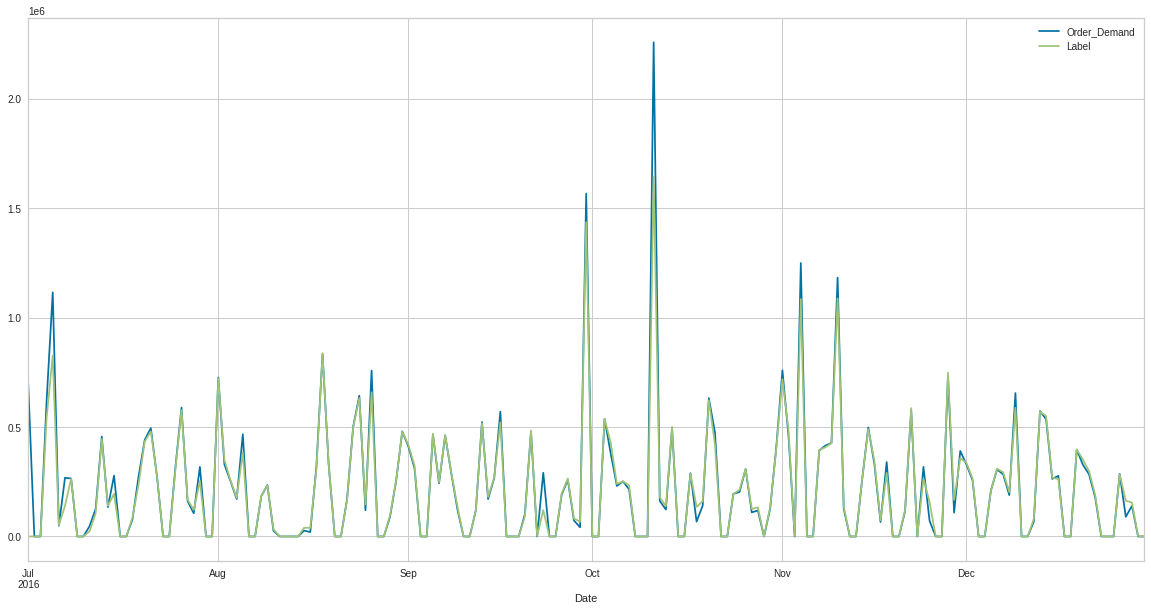

In [ ]:
new_prediction.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

# 4. ENSEMBLE DE MODELOS

In [ ]:
train3 = train2.copy()
val3 = val2.copy()
test3 = test2.copy()

In [ ]:
from pycaret.regression import *

exp_reg102 = setup(data = train3, target = 'Y1', session_id=123,
                  normalize = True, 
                  transformation = True, 
                  transform_target = True, 
                  combine_rare_levels = True, rare_level_threshold = 0.05,
                  #remove_multicollinearity = True, multicollinearity_threshold = 0.95,
                  ignore_features = ['Date','time_series'],
                  numeric_features = ['day_of_year', 'year'] + list(new_features2),
                  categorical_features = ['month', 'day_of_week', 'day'],
                  silent = True, verbose = False)

In [ ]:
# train individual models to blend
rf = create_model('rf', verbose = False)
knn = create_model('knn', verbose = False)
lr = create_model('lr', verbose = False)

In [ ]:
blender = blend_models(estimator_list = [rf, knn, lr])

,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,21567.3811,1.322301e+09,36363.4552,0.9906,3.1125,0.0976
1,23692.2212,1.455497e+09,38150.9821,0.9794,3.8834,0.0998
2,25858.1800,1.764119e+09,42001.4149,0.9821,3.9894,0.2306
3,22137.6598,1.467275e+09,38305.0310,0.9863,3.1251,0.1111
4,20740.7960,1.060327e+09,32562.6647,0.9849,3.3891,0.1913
5,15565.5780,5.418008e+08,23276.6157,0.9920,2.7566,0.0935
6,20507.5461,1.029505e+09,32085.8969,0.9838,2.7362,0.0912
7,18085.0386,6.836241e+08,26146.2065,0.9898,3.0905,0.1068
8,21006.2843,1.106030e+09,33257.0265,0.9895,3.6031,0.1633
9,19559.9654,1.077374e+09,32823.3696,0.9905,3.9063,0.0961


In [ ]:
tuned_blender = tuned_model(blender)

TypeError: ignored

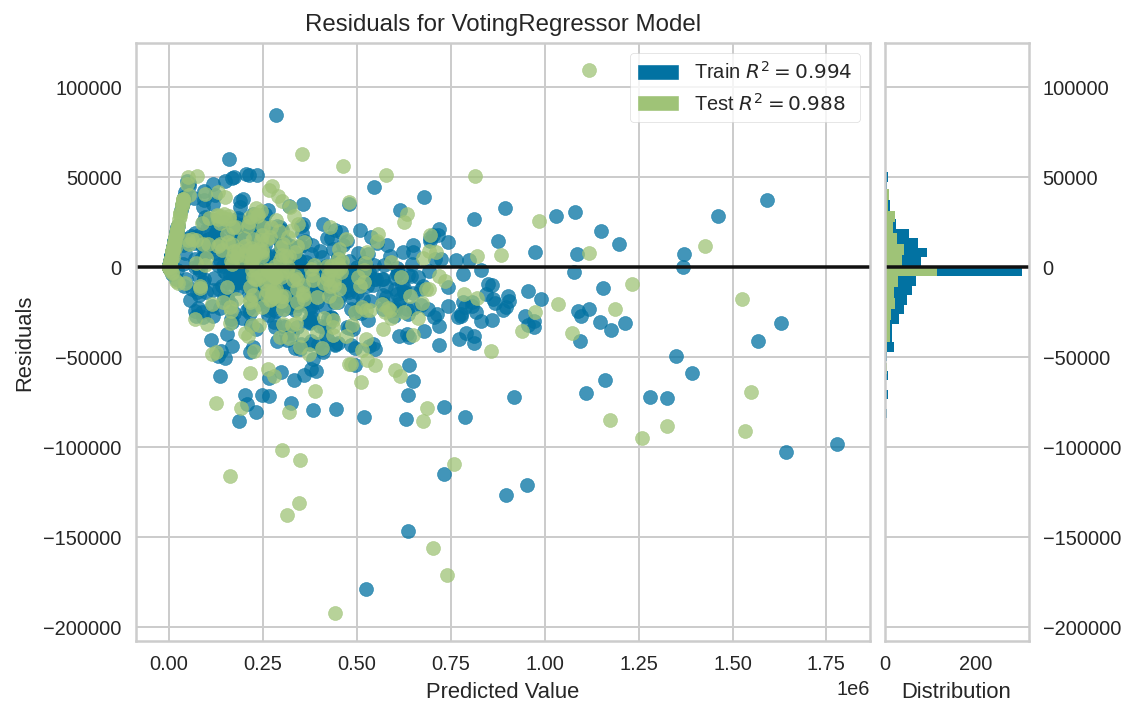

In [ ]:
plot_model(blender, scale=2)

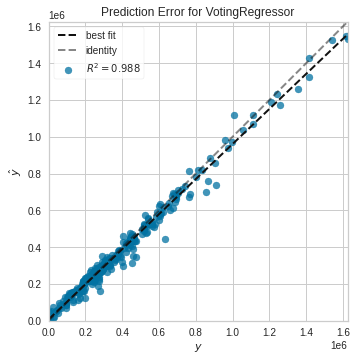

In [ ]:
plot_model(blender, plot = 'error')

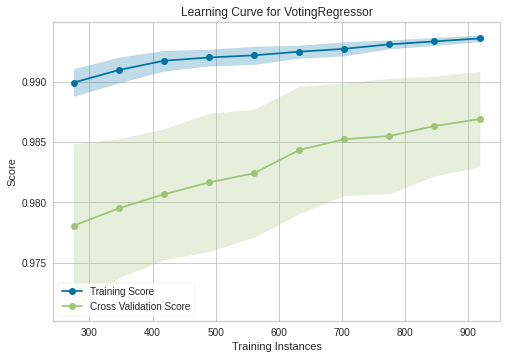

In [ ]:
plot_model(blender, plot = 'learning')

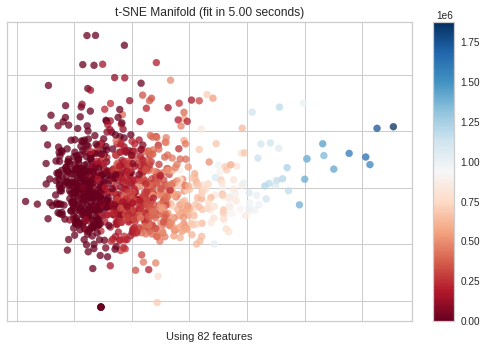

In [ ]:
plot_model(blender, plot = 'manifold')

 ## 4.1 Predict on Test / Hold-out Sample

In [ ]:
predict_model(blender);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,19337.0239,1.021019e+09,31953.3872,0.9884,3.3046,0.1485


## 4.2 Finalize Model for Deployment

In [ ]:
final_voting = finalize_model(blender)

In [ ]:
print(final_voting)

VotingRegressor(estimators=[('rf',
                             RandomForestRegressor(bootstrap=True,
                                                   ccp_alpha=0.0,
                                                   criterion='mse',
                                                   max_depth=None,
                                                   max_features='auto',
                                                   max_leaf_nodes=None,
                                                   max_samples=None,
                                                   min_impurity_decrease=0.0,
                                                   min_impurity_split=None,
                                                   min_samples_leaf=1,
                                                   min_samples_split=2,
                                                   min_weight_fraction_leaf=0.0,
                                                   n_estimators=100, n_jobs=-1,
                          

In [ ]:
predict_model(final_voting);

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Voting Regressor,9983.8019,2.350978e+08,15332.8987,0.9973,2.7385,0.0642


## 4.3 Predict on Unseen Data

In [ ]:
unseen_predictions_voting = predict_model(final_voting, data=val3)
unseen_predictions_voting.head()

,Date,Order_Demand,time_series,day,month,year,day_of_week,day_of_year,week,Y1,LAG2_Order_Demand,DIFF2_Order_Demand,ROLL_MEAN2_Order_Demand,ROLL_MAX2_Order_Demand,ROLL_MIN2_Order_Demand,DELTA_ROLL_MEAN2_Order_Demand,LAG4_Order_Demand,DIFF4_Order_Demand,ROLL_MEAN4_Order_Demand,ROLL_MAX4_Order_Demand,ROLL_MIN4_Order_Demand,DELTA_ROLL_MEAN4_Order_Demand,LAG7_Order_Demand,DIFF7_Order_Demand,ROLL_MEAN7_Order_Demand,ROLL_MAX7_Order_Demand,ROLL_MIN7_Order_Demand,DELTA_ROLL_MEAN7_Order_Demand,LAG15_Order_Demand,DIFF15_Order_Demand,ROLL_MEAN15_Order_Demand,ROLL_MAX15_Order_Demand,ROLL_MIN15_Order_Demand,DELTA_ROLL_MEAN15_Order_Demand,LAG30_Order_Demand,DIFF30_Order_Demand,ROLL_MEAN30_Order_Demand,ROLL_MAX30_Order_Demand,ROLL_MIN30_Order_Demand,DELTA_ROLL_MEAN30_Order_Demand,LAG60_Order_Demand,DIFF60_Order_Demand,ROLL_MEAN60_Order_Demand,ROLL_MAX60_Order_Demand,ROLL_MIN60_Order_Demand,DELTA_ROLL_MEAN60_Order_Demand,Label
3206091,2016-01-01,0.0,warehouse_Whse_J_Product_CodeProduct_1359,1,1,2016,4,1,53,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1265.918944
3206092,2016-01-02,0.0,warehouse_Whse_J_Product_CodeProduct_1359,2,1,2016,5,2,53,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1266.143636
3206093,2016-01-03,0.0,warehouse_Whse_J_Product_CodeProduct_1359,3,1,2016,6,3,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1266.307364
3206094,2016-01-04,0.0,warehouse_Whse_J_Product_CodeProduct_1359,4,1,2016,0,4,1,479000.0,0.0,0.0,0.0,0.0,0.0,0.0,-1.0,-1.0,0.0,0.0,0.0,0.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,1893.264675
3206095,2016-01-05,479000.0,warehouse_Whse_J_Product_CodeProduct_1359,5,1,2016,1,5,1,605000.0,0.0,479000.0,239500.0,479000.0,0.0,239500.0,0.0,479000.0,119750.0,479000.0,0.0,359250.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,412676.593750


In [ ]:
# Metrics
from pycaret.utils import check_metric
print(check_metric(unseen_predictions_voting.Order_Demand, unseen_predictions_voting.Label, 'R2'))
print(check_metric(unseen_predictions_voting.Order_Demand, unseen_predictions_voting.Label, 'MAE'))

0.988
18328.1215


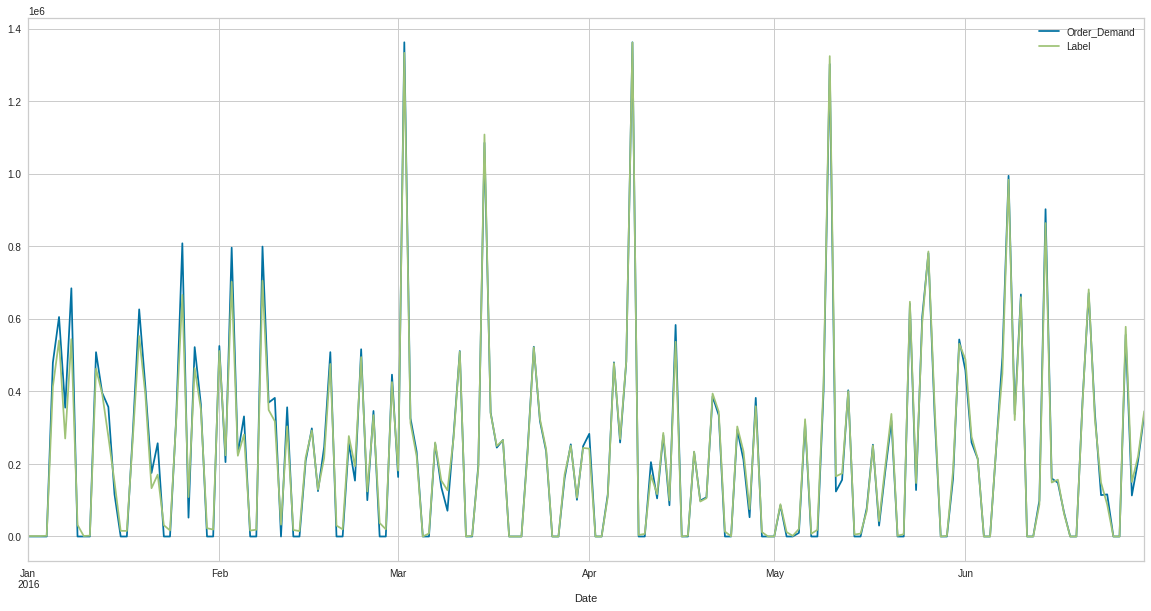

In [ ]:
unseen_predictions_voting.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)

## 4.4 Saving the Model

In [ ]:
save_model(final_voting,'Final Voting Model 1359 28 Jun 2021')

Transformation Pipeline and Model Succesfully Saved


(Pipeline(memory=None,
          steps=[('dtypes',
                  DataTypes_Auto_infer(categorical_features=['month',
                                                             'day_of_week',
                                                             'day'],
                                       display_types=False,
                                       features_todrop=['Date', 'time_series'],
                                       id_columns=[], ml_usecase='regression',
                                       numerical_features=['day_of_year',
                                                           'year'],
                                       target='Order_Demand',
                                       time_features=[])),
                 ('imputer',
                  Simple_Imputer(categorical_strategy='not_availabl...
                                                                     n_jobs=-1,
                                                                     oob

## 4.5 Loading the Saved Model

In [ ]:
saved_final_volting = load_model('Final Voting Model 1359 28 Jun 2021')

Transformation Pipeline and Model Successfully Loaded


In [ ]:
new_prediction_voting = predict_model(saved_final_volting, data=test3)
new_prediction_voting.head()

KeyError: ignored

In [ ]:
from pycaret.utils import check_metric
print(check_metric(new_prediction_voting.Order_Demand, new_prediction_voting.Label, 'R2'))
print(check_metric(new_prediction_voting.Order_Demand, new_prediction_voting.Label, 'MAE')) 

0.9584
19993.1982


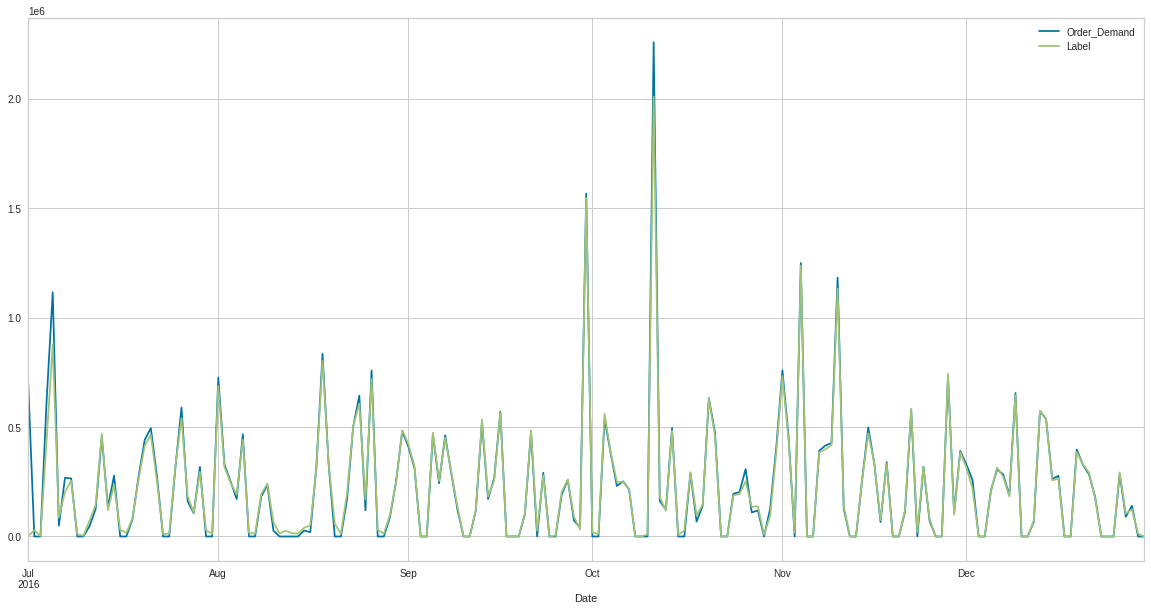

In [ ]:
new_prediction_voting.plot(x='Date', y=['Order_Demand', 'Label'], figsize=(20,10), grid=True)